**Background:** Predicting IDC in Breast Cancer Histology Images

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer.  Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

In this assignment, we will use machine learning approach to identify IDC when it is present in otherwise unlabeled histopathology images.  The dataset consists of approximately five thousand 50x50 pixel RGB digital images of color stained breast histopathology samples that are labeled as either IDC or non-IDC. 

For easy importing, the digital images are extracted from breast tissue samples and saved as numpy arrays. Each image patch is a 50x50x3 image with 3 color channels representing red, blue and green (RBG). Therefore, The breast tissue contains many cells but only some of them are cancerous.  Images that are labeled "1" contain cells that are characteristic of invasive ductal carcinoma.

The questions to answer in this assignment are summarized as follows:

Total 100 points plus 10 points from the bonus question:

* Q1 (10 points): create training and testing
* Q2 (20 points): evaluate logistic regression (overfitting detected)
* Q3 (10 points): principal component analysis to reduce 7500 features to 10 PCs
* Q4 (10 points): run LR on PCA-transformed data
* Q5 (20 points): 5-fold cross-validation and ROC curve on LR with and without PCA transformation (I thought them ROC and CV in class in lecture 31 with example code).
* Q6 (30 points): Method comparison 5-fold CV on 5 different methods with and without PCA (i.e, 10 methods to compare) and draw ROC curve.
* Bonus (10 bonus): run convolutional neural network on the full 5000 imaging data

I will be working with only **500** out of the 5000 labelled images. The following code snippet (commented out on purpose) subsamples randomly 500 samples and saves it in the data directory. 

In [76]:
import numpy as np
from matplotlib import pyplot
import matplotlib.pylab as plt
from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import random 

In [77]:
# X = np.load('X.npy') # images
# Y = np.load('Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)
# random.seed(9001)
# idx = np.array(random.sample(range(Y.shape[0]), 500))
# X = X[idx] / 256.0 # normalize the data within range 0 and 1
# Y = Y[idx]

# np.save('A5_X.npy',X)
# np.save('A5_Y.npy',Y)

Load the subsampled image and label data

In [78]:
X = np.load('A5_X.npy') # images
Y = np.load('A5_Y.npy') # labels associated to images (0 = no IDC, 1 = IDC)

print some simple statistics of the data as follows:

In [79]:
print('Total number of images: {}'.format(len(X)))
print('Number of IDC(-) Images: {}'.format(np.sum(Y==0)))
print('Number of IDC(+) Images: {}'.format(np.sum(Y==1)))
print('Percentage of IDC(+) images: {:.2f}%'.format(100*np.mean(Y)))
print('Image shape (Width, Height, Channels): {}'.format(X[0].shape))

Total number of images: 500
Number of IDC(-) Images: 235
Number of IDC(+) Images: 265
Percentage of IDC(+) images: 53.00%
Image shape (Width, Height, Channels): (50, 50, 3)


We can visiualize the image data as follows:

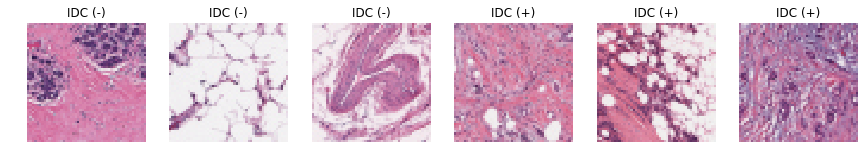

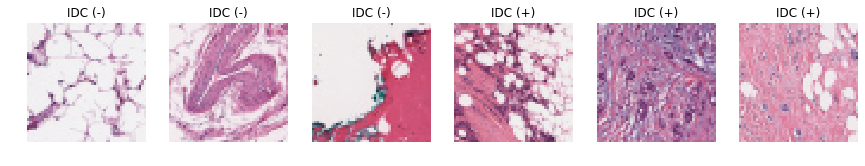

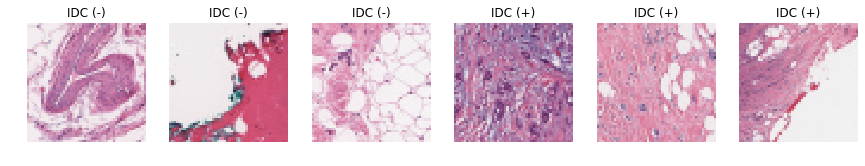

In [80]:
def plotImg(X0,X1):
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3): # plot 3 IDC(-) and 3 IDC(+) in one row
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(X0[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(X1[row+col])
            plt.axis('off')
            
plotImg(X[Y==0], X[Y==1])

The machine learning methods used are not capable of operating on two-dimensional color images (i.e., 3D numpy array). 

To make them applicable to the data, I will need to **flatten** the image to represent them as 1D features

In [81]:
X_shape = X.shape[1]*X.shape[2]*X.shape[3]

X_flat = X.reshape(X.shape[0], X_shape)

X_flat.shape


(500, 7500)

This gives a 500 x 7500 array with 500 images of 7500 features (i.e., $50 \times 50 \times 3 = 7500$)

**Part 1: training and testing**

First, split the data into 80% training and 20% testing set

In [82]:
X = X_flat.copy()
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,test_size=0.2, shuffle=True)

print("Training Data Shape:", X_train.shape, Y_train.shape)
print("Testing Data Shape:", X_test.shape, Y_test.shape)

Training Data Shape: (400, 7500) (400,)
Testing Data Shape: (100, 7500) (100,)


**Part 2 Train and evaluate logistic regression classifier**

Next, a function evaluateAccuracy_LR is used to evaluate the accuracy of logistic regression (LR) classifier.

I will use the training set (i.e., 80% of dataset) to train the LR classifer and use the testing set (i.e., 20% of the dataset) to evaluate my trained LR model.

In [83]:
#runLogisticRegression
def evaluateAccuracy_LR(train_x, train_y, test_x, test_y): 
    
    # YOUR CODE HERE
    Lr_model = LogisticRegression(solver='liblinear')
    fit = Lr_model.fit(train_x, train_y)
    Y_train_pred = fit.predict(train_x)
    Y_test_pred = fit.predict(test_x)
    
    acc_train = sum(Y_train_pred==train_y)/len(train_y)
    acc_test = sum(Y_test_pred==test_y)/len(test_y)
    
    tn,fp,fn,tp = confusion_matrix(test_y,Y_test_pred).ravel()
    tpr_test = tp/float(tp + fn)
    fpr_test = fp/float(fp + tn)
    
    tn,fp,fn,tp = confusion_matrix(train_y,Y_train_pred).ravel()
    tpr_train = tp/float(tp + fn)
    fpr_train = fp/float(fp + tn)

    return acc_train,tpr_train,fpr_train,acc_test,tpr_test,fpr_test

In [84]:
acc_train,tpr_train,fpr_train,acc_test,tpr_test,fpr_test = evaluateAccuracy_LR(X_train, Y_train, X_test, Y_test)


print(f"Train: accuracy: {acc_train:.2}, TPR: {tpr_train:.2}, FPR: {fpr_train:.2}")
print(f"Testing: accuracy: {acc_test:.2}, TPR: {tpr_test:.2}, FPR: {fpr_test:.2}")

Train: accuracy: 1.0, TPR: 1.0, FPR: 0.0
Testing: accuracy: 0.63, TPR: 0.6, FPR: 0.33


As we can see above, we obtained perfect training performance and much worse testing performance. This implies a severe overfitting of the data.

I have 7500 features for only 500 training examples. Even if I use the full 5000 examples, the number of examples is still lower than the number of features. This is commonly known as the "curse of dimensionality", which in some sense implies that models like logistic regression (without successful sparse regularization) will be doomed to overfit the data.

To address this issue, I will use an _a priori_ feature selection technique called ***Principal Component Analysis*** (PCA) that reduces the dimensionality of the problem. PCA is an unsupervized learning technique. The basic idea behind PCA is to rotate the co-ordinate axes of the feature space. I first find the direction in which the data varies the most. I set up one co-ordinate axes along this direction, which is called the first principal component. We then look for a perpendicular direction in which the data varies the second most. This is the second principal component. The diagram illustrates this process. There are as many principal components as the feature dimension: all we have done is a rotation.

We'll reduce our dimensionality from 7500 to **10** principal components (PCs).

![pcanim](pcanim.gif)

(diagram taken from http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues which also has nice discussions)

The following code transforms the $500\times 7500$ input data to $500\times10$ data with 10 PCs

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_flat)
X_pca = pca.transform(X_flat)
X_pca.shape

(500, 10)

We can examine how much total variance the 10 PCs explain:

In [86]:
pca.explained_variance_ratio_.sum()

0.6043096408759617

In total, 10 PCs can explain 60% of the total variance, which is sufficient for the purpose of this assignment

Also, I can examine how much variance each PC explains:

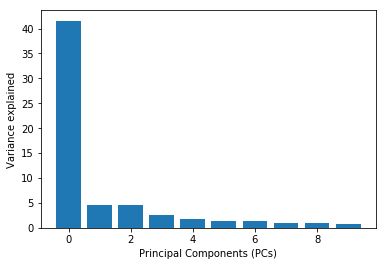

In [87]:
plt.bar(range(10), pca.explained_variance_ratio_*100)
plt.xlabel("Principal Components (PCs)")
plt.ylabel("Variance explained")
plt.show()

From the above bar plot, we see that the first 3 PCs explain substantially more variance than the rest of the 7 PCs.

In [88]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()
pca.fit(X_train2)
X_train_PCA = pca.transform(X_train2)
X_test_PCA = pca.transform(X_test2)

The first three PCs are plotted in a three-dimensional scatter plot with PC1 in x-axis, PC2 in y-axis, and PC3 in z-axis. The IDC(+) are colored in red and the IDC(-) are colored in blue; circle 'o' represents training data points and 'x' represents testing data points.

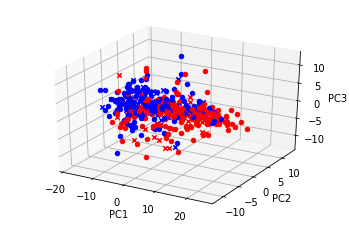

In [89]:
from mpl_toolkits.mplot3d import Axes3D

#YOUR CODE HERE
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X_train_PCA)):
    if Y_train[i]>0:
        ax.scatter(X_train_PCA[i, 0], X_train_PCA[i, 1],X_train_PCA[i, 2],
                   zdir='z', s=20, c='r', depthshade=True, marker='o')
    else:
        ax.scatter(X_train_PCA[i, 0], X_train_PCA[i, 1],X_train_PCA[i, 2],
                   zdir='z', s=20, c='b', depthshade=True, marker='o')

for i in range(len(X_test_PCA)):
    if Y_test[i]>0:
        ax.scatter(X_test_PCA[i, 0], X_test_PCA[i, 1], X_test_PCA[i, 2],
                   zdir='z', s=20, c='r', depthshade=True, marker='x')
    else:
        ax.scatter(X_test_PCA[i, 0], X_test_PCA[i, 1], X_test_PCA[i, 2],
                   zdir='z', s=20, c='b', depthshade=True, marker='x')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.dist= 10.7

**Part 4 Evaluation of the logistic regression using the 10 PCs**

In [90]:
Lr_model = LogisticRegression(solver='liblinear')
fit = Lr_model.fit(X_train_PCA, Y_train)
y_train_pred = fit.predict(X_train_PCA)
Y_test_pred = fit.predict(X_test_PCA)
    
acc_train = sum(y_train_pred==Y_train)/len(Y_train)
acc_test = sum(Y_test_pred==Y_test)/len(Y_test)   

tn,fp,fn,tp = confusion_matrix(Y_test,Y_test_pred).ravel()
tpr_test = tp/float(tp + fn)
fpr_test = fp/float(fp + tn)
    
tn,fp,fn,tp = confusion_matrix(Y_train,y_train_pred).ravel()
tpr_train = tp/float(tp + fn)
fpr_train = fp/float(fp + tn)
print(f"Train: accuracy: {acc_train:.2}, TPR: {tpr_train:.2}, FPR: {fpr_train:.2}")
print(f"Testing: accuracy: {acc_test:.2}, TPR: {tpr_test:.2}, FPR: {fpr_test:.2}")


Train: accuracy: 0.76, TPR: 0.75, FPR: 0.22
Testing: accuracy: 0.76, TPR: 0.75, FPR: 0.23


We see a much better performance on the testing set and also no obvious overfitting occurs after the PCA dimensionality reduction!

**Part 5: Five-fold Cross Validation**

Instead of evaluting the model only on the 20% of data, it is evaluated on ALL of the data points via implementation of a 5-fold cross-validation. 

For comparison, the same 5-fold CV is also implemented using the LR model operating on the _untransformed_ 7500-features data.


Then, the performances between the LR on PCA-transformed 10-dimensional dataset is compared with the LR on the original 7500-dimensional dataset.

In [103]:
def cross_validate(model, X_input, Y_output, pca_transform=False):
    """
        Input:
            model: A sklearn machine learning model object
            X_input: a numpy array for the input data 
            Y_output: output label
            pca_transform: a boolean variable indicate whether PCA should be applied to transform the training and validation data to 10-PCs before applying the machine learning model
        Returns:
            true_labels: Y_output but saved in the same order of the cross-validation folds
            pred_scores: predicted scores or probabilities for each CV
    """
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    true_labels = np.array([0] * X_input.shape[0])
    pred_scores = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        true_labels[test_index] = Y_output[test_index]
        pred_scores[test_index] = model.predict_proba(X_input[test_index])[:,1]
        
    return (true_labels, pred_scores)

The cross-validation implmented above is run using LR on PCA transformation and LR on original data. 

In [104]:
true_labels_PCA,pred_scores_PCA = cross_validate(Lr_model,X_train_PCA,Y_train,pca_transform=True)
fpr_PCA, tpr_PCA, thresholds_PCA = roc_curve(true_labels_PCA, pred_scores_PCA)
auc_PCA = roc_auc_score(true_labels_PCA, pred_scores_PCA)

true_labels,pred_scores = cross_validate(Lr_model,X_train,Y_train, pca_transform=False)
fpr, tpr, thresholds = roc_curve(true_labels, pred_scores)
auc = roc_auc_score(true_labels, pred_scores)


The ROC curves are plotted for both the PCA-LR and LR on the same plot.

Text(0, 0.5, 'True Positive Rate')

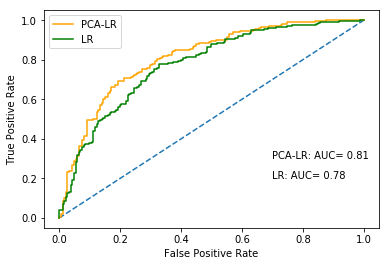

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
ax.plot(fpr_PCA, tpr_PCA,color='orange', label='PCA-LR')
ax.plot(fpr, tpr,color='green',label='LR')

ax.text(0.7, 0.2, 'LR: AUC= '+str(round(auc,2)))
ax.text(0.7, 0.3, 'PCA-LR: AUC= '+str(round(auc_PCA,2)))

pyplot.legend(loc='upper left', bbox_to_anchor=(0, 1))
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")

There is a 6% increase in AUC for LR operating on the 10 PCs compared to the LR operating on 7500 features!

**Part 6: Compare several classifiers**

Using the $\texttt{cross_validation}$ function implemented above, the following classifiers are experimented:

1. LogisticRegression(solver="liblinear")
2. KNeighborsClassifier()
3. SVC(probability=True, gamma='auto')
4. DecisionTreeClassifier()
5. RandomForestClassifier(n_estimators=100)

Note each of the initializers creates a classifier object of the class so that we can pass them to cross_validation function directly without hard coding the specific classifier you want to use inside the function.

In [106]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = [LogisticRegression(solver="liblinear"), KNeighborsClassifier(), SVC(probability=True, gamma='auto'), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)]

perf = {}

for model in models:
    model_name = type(model).__name__
    
    label_PCA,pred_PCA = cross_validate(model, X_train_PCA,Y_train,pca_transform=True)
    fpr_PCA, tpr_PCA, thresholds_PCA = roc_curve(label_PCA, pred_PCA)
    auc_PCA = roc_auc_score(label_PCA, pred_PCA)
    
    label,pred = cross_validate(model, X_train,Y_train,pca_transform=False)
    fpr, tpr, thresholds_PCA = roc_curve(label, pred)
    auc = roc_auc_score(label, pred)
    
    perf[model_name] = {'fpr_PCA':fpr_PCA,'tpr_PCA':tpr_PCA,'auc_PCA':auc_PCA,'fpr':fpr,'tpr':tpr,'auc':auc}    

Text(0, 0.5, 'True Positive Rate')

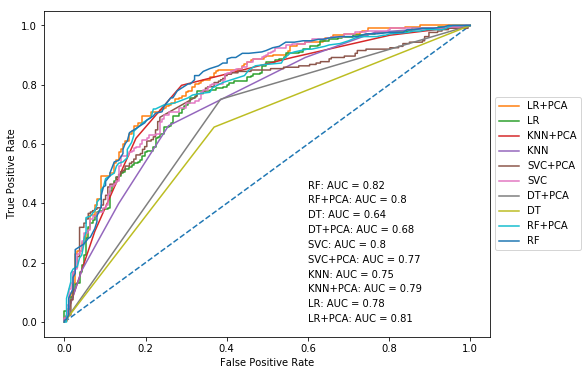

In [107]:
 
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], linestyle='--')

model_abbrev = {"LogisticRegression":["LR+PCA","LR"],"KNeighborsClassifier":["KNN+PCA", "KNN"], 
                "SVC":["SVC+PCA", "SVC"], "DecisionTreeClassifier":["DT+PCA","DT"], 
                "RandomForestClassifier":["RF+PCA","RF"]}

i = 0
for model_name, model_perf in perf.items():    
    mymodel = model_abbrev[model_name][0]
    ax.plot(model_perf['fpr_PCA'], model_perf['tpr_PCA'], label=mymodel)
    ax.text(0.6, i, mymodel + ': AUC = '+str(round(model_perf['auc_PCA'],2)))    
    i += 0.05
    
    mymodel_1 = model_abbrev[model_name][1]
    ax.plot(model_perf['fpr'], model_perf['tpr'], label=mymodel_1)
    ax.text(0.6, i, mymodel_1 + ': AUC = '+str(round(model_perf['auc'],2)))

    i += 0.05

pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")




As we can see not that all of the methods significantly benefit from PCA transformation. Some of the reasons are: 
* Some of the methods themselves have built-in feature selection algorithm such as RF and DT instead of trying to fit all of the features as in the LR
* SVC transforms the data to hyperplane which is linearly separaable and often do not benefit from external PCA transformation

The best I obtain from this analysis is: *Random Forest* (RF) without PCA transformation with AUC = 0.82 or 0.83 and LR with PCA transformation AUC = 0.81

I will use RF to compare with a convolutional neural network below.

**Part 7: Running Convoluational Neural Network (CNN) with Keras**

Until now, I treated the image features as flat independent 7500 features. However, images have spatial information in them. For instance, pixels adjacent to each other tend to look more similar than those that are far apart. 

I would like to move an imaginary lense across the image and extract meaningful image features to help classify breast cancer samples.

To this end, I will use *Convoluational Neural Network* (CNN). CNN is a member of the Deep Learning model family that specifically suitable for image inputs. 

![title](Deep_Convolutional_Neural_Networks_for_Breast_Canc.jpg)

The above figure was extracted from the following paper: 
https://arxiv.org/abs/1802.00752

I will use Keras to train a CNN. Keras is a high-level wrapper library of Google TensorFlow and provide simpler API for training neural network with customized architectures. When running on a GPU computer, Keras/TensorFlow will automatically use the GPU for the computing without additional efforts to configure it.

My CNN will not be as "deep" as the one shown above in terms of the number of network layers because that will take long time to run.

In [117]:
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

In [118]:
def trainCNN(x_train, y_train):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    num_classes = 2

    img_rows, img_cols = x_train.shape[1],x_train.shape[2]            
    
    input_shape = (img_rows, img_cols, 3)

    model = Sequential()        
    
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images    
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    model.fit_generator(datagen.flow(x_train, y_train,batch_size=32),
                        steps_per_epoch=len(x_train) / 32, 
                        epochs=12,
                        verbose=1)
        
    return model

Building the CNN model is sequential which allows me to create it layer-by-layer. The architecture consists of two convolutional layers, one max pooling layer, one dropout layer, one flatten layer (2D to 1D), one fully connected layers, another dropout layer, and finally the output layer with sigmoid activation output unit for prediction.

I also include a data augmentation step to learn rotation and translation invariant features

In [119]:
X = np.load('X.npy')/256.0
Y = np.load('Y.npy')

print(X.shape) # (5547, 50, 50, 3)
print(Y.shape) # (5547,)

(5547, 50, 50, 3)
(5547,)


Implementation of the cross validation for the CNN model. 

I need to use one-hot encoding to formulate Y into a two-column binary matrix (i.e., $5547\times 2$) with the first column indicating IDC(-) and second column indicating IDC(+).


In [120]:
def cross_validate_cnn(X, Y):
    
    # YOUR CODE HERE
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    true_labels = np.array([0] * X.shape[0])
    pred_scores = np.array([0.0] * X.shape[0])
    Y_onehot = to_categorical(Y, num_classes = 2)

    for train_index, test_index in kf.split(X):        
        cnn_model = trainCNN(X[train_index], Y_onehot[train_index])
        true_labels[test_index] = Y[test_index]
        pred_scores[test_index] = cnn_model.predict(X[test_index])[:,1]
    return (true_labels, pred_scores)    

I then do a 5-fold CV on the CNN model using all of the 5000 images. 

In [121]:
true_labels,pred_scores = cross_validate_cnn(X, Y)

Epoch 1/12
139/138 [==============================] - 68s 489ms/step - loss: 0.7689 - acc: 0.5427
Epoch 2/12
139/138 [==============================] - 67s 483ms/step - loss: 0.6694 - acc: 0.6154
Epoch 3/12
139/138 [==============================] - 62s 446ms/step - loss: 0.6321 - acc: 0.6628
Epoch 4/12
139/138 [==============================] - 54s 391ms/step - loss: 0.6018 - acc: 0.6987
Epoch 5/12
139/138 [==============================] - 58s 417ms/step - loss: 0.5721 - acc: 0.7251
Epoch 6/12
139/138 [==============================] - 56s 405ms/step - loss: 0.5709 - acc: 0.7285
Epoch 7/12
139/138 [==============================] - 54s 390ms/step - loss: 0.5530 - acc: 0.7408
Epoch 8/12
139/138 [==============================] - 56s 403ms/step - loss: 0.5466 - acc: 0.7450
Epoch 9/12
139/138 [==============================] - 58s 414ms/step - loss: 0.5413 - acc: 0.7483
Epoch 10/12
139/138 [==============================] - 54s 386ms/step - loss: 0.5360 - acc: 0.7463
Epoch 11/12
139/138

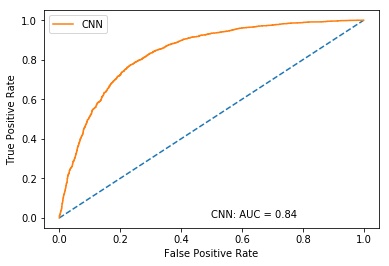

In [122]:
perf2 = {}

fpr, tpr, thresholds = roc_curve(true_labels, pred_scores)
auc = roc_auc_score(true_labels, pred_scores)
perf2["CNN"] = {'fpr':fpr,'tpr':tpr,'auc':auc}    
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], linestyle='--')

i = 0
for mymodel, model_perf in perf2.items():    
    ax.plot(model_perf['fpr'], model_perf['tpr'], label=mymodel)
    ax.text(0.5, i, mymodel + ': AUC = '+str(round(model_perf['auc'],2)))
    i += 0.1

pyplot.legend(loc='best')    
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")
pyplot.savefig('roc_CNN.png')

### Reference: ###

For more information about the data, see https://www.ncbi.nlm.nih.gov/pubmed/27563488 and http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872.

For more information about IDC and breast cancer, please review the following publications: 
* https://www.ncbi.nlm.nih.gov/pubmed/27864452
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3893344/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4952020/
* https://arxiv.org/abs/1802.00752 (Deep learning approach)